In [1]:
##############################################################################
# What is PsyNeuLink?
#
# PsyNeuLink is an integrated language and toolkit for creating
# cognitive models. It decreases the overhead required for cognitive
# modeling by providing standard building blocks (DDMS, Neural Nets, etc.)
# and the means to connect them together in a single environment.
# PsyNeuLink is designed to make the user think about computation
# in a "mind/brain-like" way while imposing minimal constraint
# on the type of models that can be implemented.
##############################################################################

In [2]:
##############################################################################
# How do I get PsyNeuLink?
# 
# Go to https://github.com/PrincetonUniversity/PsyNeuLink
# Press the green "Clone or download" button, then "Download ZIP"
# Unzip in the directory of your choice.
#
# Right now, you need explicit permission to download PsyNeuLink,
# so if you can't follow these directions, this is likely the reason.
#
# Note to Jon: Should I teach them with these directions or should I
# teach them to use git clone?
#
# Once you have downloaded the repository, move this file to the main PsyNeuLink
# folder and restart the kernel from the jupyter toolbar.
##############################################################################

In [3]:
# Run this cell to download required packages.
! pip3 install toposort
! pip3 install mpi4py

In [4]:
##############################################################################
# What will we do in this tutorial?
#
# This tutorial is meant to get you accustomed to the basic structure of PsyNeuLink
# and be able to construct basic models. Starting with a simple 1-to-1 transformation,
# we will build up to making a Stroop model and reinforcement learning agent
##############################################################################

In [5]:
# First we need to import the necessary packages. Right now, these lines only work from
# files in this directory, but eventually PsyNeuLink will be an installable python package.

# This first package contains the basic methods to create and handle Processes,
# which we will discuss later.
from PsyNeuLink.Functions.Process import *

# The second imports a specific type of mechansim, a Transfer mechanism, that we will be
# using in this tutorial.
from PsyNeuLink.Functions.Mechanisms.ProcessingMechanisms.Transfer import Transfer
from PsyNeuLink.Functions.Utility import Linear

In [6]:
# Now we import tools for plotting so we can see what our mechanisms do.
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [7]:
# If this doesn't work, execute this cell to download the packages, then rerun the import statements
! pip3 install numpy
! pip3 install matplotlib

In [8]:
# Now we are ready to create our first mechanism. A mechanism is the basic unit
# of computation in PsyNeuLink. It takes inputs, runs them through a function, 
# then provides outputs. First we will make a Transfer mechanism that performs a
# linear transformation on its input. In this case, we didn't actually need to
# specify the slope and intercept as the mechanism will default to reasonable
# values (in this case, 1 and 0 respectively).

linear_transfer_mechanism = Transfer(function=Linear(slope = 1, intercept = 0))

In [ ]:
# The "Transfer" function creates a new transfer mechanism.
linear_transfer_mechanism = Transfer(name = mechanism_name, params = mechanism_params)

In [9]:
# Now we have to put our mechanism in a process. In PsyNeuLink, a process is
# a collection of mechanisms and projections (which we will learn about later)
# connected in a certain configuration to be executed.
# Since we only have one mechanism, the configuration list has only one element.
# We will leave the other parameters to default.
process_params = {CONFIGURATION:[linear_transfer_mechanism]}

linear_transfer_process = Process_Base(params = process_params)


Process-1 initialized with:
- configuration: ['Transfer-1']


In [10]:
# Now we can run our process. Since our only mechanism is the 1-to-1 linear
# mechanism, the process output should be the same as its input.
linear_transfer_process.execute([1])



****************************************

Process-1 executing with:
- configuration: ['Transfer-1']
- input: 1

Transfer-1 mechanism:
- input:  1.
- params:
    length: 1 
    input:  1. 
    value range:  
- output: 
    mean output: 1.0 
    output variance: 0.0
Output:   1.

Transfer-1 Mechanism executed:
- output:  1.

Process-1 executed Transfer-1:
- output:  1.

--------------------------------------

Process-1 completed:
- output:  1.

*********************************************



array([ 1.])

In [11]:
# Now let's see if it runs properly over a wide range of values
# First we want to get rid of some of that output. This is done by setting
# up a preference set and passing it to our mechanism. We need to set this both for
# our mechanism(s) and our process(es)

mechanism_prefs = FunctionPreferenceSet(
                   prefs = {
                    kpVerbosePref: PreferenceEntry(False,PreferenceLevel.INSTANCE),
                    kpReportOutputPref: PreferenceEntry(False,PreferenceLevel.INSTANCE)})
linear_transfer_mechanism.prefs = mechanism_prefs
process_prefs = FunctionPreferenceSet(
                 prefs = {
                  kpVerbosePref: PreferenceEntry(False,PreferenceLevel.INSTANCE),
                  kpReportOutputPref: PreferenceEntry(False,PreferenceLevel.INSTANCE)})
linear_transfer_process.prefs = process_prefs
# Notice that while process and mechanism params are passed in a dictionary, prefs are
# packaged in a FunctionPreferenceSet object

In [12]:
### EXERCISE 1 ###
# Let's check to make sure our preferences suppress the output.
# Type your own code to execute the process with an input of 2

linear_transfer_process.execute([2])

array([ 2.])

---------------------------------------------------

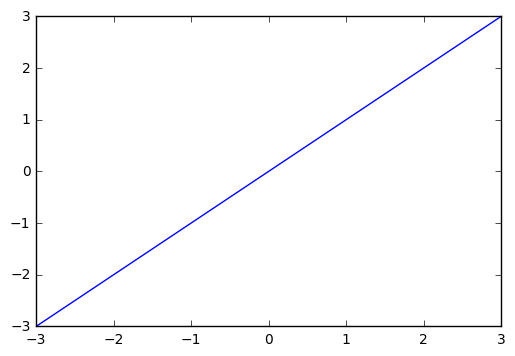

In [13]:
# Finally, let's see the output of our process over a range of values using pyplot
xVals = np.linspace(-3, 3, num=51)
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    # Progress bar
    print("-", end="")
    yVals[i] = linear_transfer_process.execute([xVals[i]])[0]
plt.plot(xVals, yVals)
plt.show()

In [ ]:
# Now let's put it all together and make a new logistic transfer process
# Create the mechanism
mechanism_name = "Logistic Transfer Mechanism"
mechanism_params = {FUNCTION:Logistic}
logistic_transfer_mechanism = Transfer(name = mechanism_name, params = mechanism_params)

# Package into a process
process_name = "Logistic Transfer Process"
process_params = {CONFIGURATION:[logistic_transfer_mechanism]}
logistic_transfer_process = Process_Base(name = process_name, params = process_params)

# Test execution
logistic_transfer_process.execute([1])

# Silence output
mechanism_prefs = FunctionPreferenceSet(
                   prefs = {
                    kpVerbosePref: PreferenceEntry(False,PreferenceLevel.INSTANCE),
                    kpReportOutputPref: PreferenceEntry(False,PreferenceLevel.INSTANCE)})
logistic_transfer_mechanism.prefs = mechanism_prefs
process_prefs = FunctionPreferenceSet(
                 prefs = {
                  kpVerbosePref: PreferenceEntry(False,PreferenceLevel.INSTANCE),
                  kpReportOutputPref: PreferenceEntry(False,PreferenceLevel.INSTANCE)})
logistic_transfer_process.prefs = process_prefs

# Iterate and plot
xVals = np.linspace(-3, 3, num=51)
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    # Progress bar
    print("-", end="")
    yVals[i] = logistic_transfer_process.execute([xVals[i]])[0]
plt.plot(xVals, yVals)
plt.show()

In [ ]:
logistic_transfer_mechanism.params